## Step 4.
Build a Bayesian network for chosen set of variables. Choose its structure on the basis of multivariate analysis and train distributions in nodes using chosen algorithm.

In [1]:
import numpy as np
import scipy as sp
import sklearn as sk
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import pylab

from bayesian.train_bn import structure_learning, parameter_learning
from preprocess.discretization import get_nodes_type, discretization, code_categories, get_nodes_sign
from bayesian.save_bn import save_structure, save_params, read_structure, read_params
from bayesian.sampling import generate_synthetics
from bayesian.calculate_accuracy import calculate_acc
from external.libpgm.hybayesiannetwork import HyBayesianNetwork
from visualization.visualization import draw_BN
from sklearn.model_selection import train_test_split
from functools import partial

In [2]:
# Dataset initialization
path_to_file = '../../Datasets/Challenger_Ranked_Games.csv'
source_df = pd.read_csv(path_to_file, engine='python')

# Used features and data preparation
source_df = source_df[[ 'blueTotalHeal', # 1st target variable
                        'blueTotalGold', # 2nd target variable
                        'blueChampionDamageDealt', # 3rd target variable
                        'blueTotalMinionKills', # This and the rest are predictors
                        'blueWardPlaced',
                        'gameDuraton',
                        'blueWardkills', 
                        'blueKills', 
                        'blueDeath', 
                        'blueJungleMinionKills',
                        'blueObjectDamageDealt',
                        'blueWins']]

# Removing outliers
for col_name in source_df:
    if True: # cut by quantiles
        # Default ones
        up_quant = 0.999
        down_quant = 0.001

        if col_name == 'blueTotalGold':
            down_quant = 0.005
        elif col_name == 'blueTotalMinionKills':
            down_quant = 0.005
        if col_name != 'blueWins':
            q_low = source_df[col_name].quantile(down_quant)
            q_hi  = source_df[col_name].quantile(up_quant)

            source_df = source_df[(source_df[col_name] < q_hi) & (source_df[col_name] > q_low)]
    else: # cut by zscore
        source_df[(np.abs(scipy.stats.zscore(source_df)) < 3).all(axis=1)]    
source_df['blueWins'] = source_df['blueWins'].apply(lambda x: 'won' if x==1 else 'lost')
source_df['blueTotalMinionKills'] = source_df['blueTotalMinionKills'].astype(float)
source_df['blueWardPlaced'] = source_df['blueWardPlaced'].astype(float)
source_df['blueWardkills'] = source_df['blueWardkills'].astype(float)
source_df['blueKills'] = source_df['blueKills'].astype(float)
source_df['blueDeath'] = source_df['blueDeath'].astype(float)
source_df['blueJungleMinionKills'] = source_df['blueJungleMinionKills'].astype(float)
source_df = source_df.head(1000)
source_df.head(5)

,blueTotalHeal,blueTotalGold,blueChampionDamageDealt,blueTotalMinionKills,blueWardPlaced,gameDuraton,blueWardkills,blueKills,blueDeath,blueJungleMinionKills,blueObjectDamageDealt,blueWins
0,31.035,37.001,56.039,440.0,38.0,22.050000,13.0,15.0,31.0,105.0,5.675,lost
1,26.397,41.072,60.243,531.0,57.0,21.950000,18.0,19.0,8.0,111.0,45.303,won
2,6.567,22.929,24.014,306.0,28.0,15.533333,7.0,5.0,20.0,64.0,5.651,lost
3,24.718,63.447,101.607,774.0,129.0,34.966667,39.0,26.0,36.0,226.0,31.019,lost
4,37.161,74.955,134.826,831.0,114.0,39.066667,35.0,27.0,40.0,252.0,95.287,won


In [3]:
train, test = train_test_split(source_df, test_size=0.2, random_state=10)
train

,blueTotalHeal,blueTotalGold,blueChampionDamageDealt,blueTotalMinionKills,blueWardPlaced,gameDuraton,blueWardkills,blueKills,blueDeath,blueJungleMinionKills,blueObjectDamageDealt,blueWins
194,20.083,47.785,54.347,561.0,67.0,22.633333,27.0,23.0,14.0,201.0,53.191,won
200,68.713,61.918,99.457,666.0,90.0,29.166667,43.0,39.0,13.0,197.0,73.235,won
231,9.418,24.586,25.927,345.0,33.0,16.333333,6.0,6.0,24.0,81.0,13.956,lost
611,18.028,32.657,37.190,501.0,44.0,19.300000,10.0,6.0,22.0,123.0,22.063,lost
443,7.856,23.947,24.355,362.0,39.0,16.516667,13.0,5.0,19.0,81.0,7.440,lost
...,...,...,...,...,...,...,...,...,...,...,...,...
330,69.577,64.657,100.667,717.0,108.0,33.950000,49.0,31.0,28.0,157.0,83.772,won
553,22.705,50.154,72.199,543.0,77.0,23.283333,25.0,37.0,10.0,149.0,46.799,won
1144,22.343,53.289,80.245,603.0,65.0,23.983333,33.0,38.0,17.0,126.0,43.470,won
131,26.241,42.542,45.732,618.0,91.0,28.083333,38.0,11.0,22.0,147.0,9.291,lost


In [4]:
nodes_type = get_nodes_type(train)
print("Nodes type:\n", nodes_type)
nodes_sign = get_nodes_sign(train)
print("Nodes sign:\n", nodes_sign)

Nodes type:
 {'blueTotalHeal': 'cont', 'blueTotalGold': 'cont', 'blueChampionDamageDealt': 'cont', 'blueTotalMinionKills': 'cont', 'blueWardPlaced': 'cont', 'gameDuraton': 'cont', 'blueWardkills': 'cont', 'blueKills': 'cont', 'blueDeath': 'cont', 'blueJungleMinionKills': 'cont', 'blueObjectDamageDealt': 'cont', 'blueWins': 'disc'}
Nodes sign:
 {'blueTotalHeal': 'pos', 'blueTotalGold': 'pos', 'blueChampionDamageDealt': 'pos', 'blueTotalMinionKills': 'pos', 'blueWardPlaced': 'pos', 'gameDuraton': 'pos', 'blueWardkills': 'pos', 'blueKills': 'pos', 'blueDeath': 'pos', 'blueJungleMinionKills': 'pos', 'blueObjectDamageDealt': 'pos'}


In [5]:
bayes_manual = dict(
    {'V': [
'blueTotalHeal',
'blueTotalGold',
'blueChampionDamageDealt',
'blueTotalMinionKills',
'blueWardPlaced',
'gameDuraton',
'blueWardkills',
'blueKills',
'blueDeath',
'blueJungleMinionKills',
'blueObjectDamageDealt',
'blueWins'
        ],
    'E': [
['blueObjectDamageDealt', 'blueTotalGold'],
['blueJungleMinionKills', 'blueTotalGold'],
['blueTotalMinionKills', 'blueTotalGold'],
['blueWardkills', 'blueTotalGold'],
['blueWardPlaced', 'blueTotalGold'],
['gameDuraton', 'blueTotalGold'],
['gameDuraton', 'blueChampionDamageDealt'],
['blueKills', 'blueTotalGold'],
['blueTotalGold', 'blueTotalHeal'],
['gameDuraton', 'blueTotalHeal'],
['blueKills', 'blueChampionDamageDealt'],
    ]
    }
)
print("Obtained network structure", bayes_manual)
draw_BN(bayes_manual, nodes_type, 'bayes_manual')

C:\Users\Professional\AppData\Local\Programs\Python\Python39\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\Users\Professional\AppData\Local\Programs\Python\Python39\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\Users\Professional\AppData\Local\Programs\Python\Python39\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt you

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

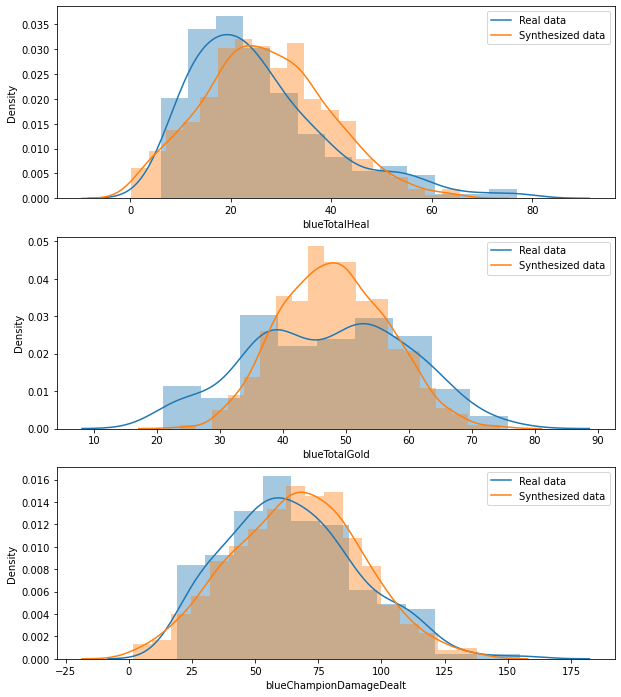

In [6]:
params = parameter_learning(train, nodes_type, bayes_manual, 'simple')
save_structure(bayes_manual, 'bayes_manual_structure')
skel = read_structure('bayes_manual_structure')
save_params(params, 'bayes_manual_params')
params = read_params('bayes_manual_params')
bayes_manual = HyBayesianNetwork(skel, params)
synth_df = generate_synthetics(bayes_manual, nodes_sign, 'simple', 800)

figure, axes = plt.subplots(3, 1, figsize=(10, 12))


sns.distplot(test['blueTotalHeal'], ax=axes[0])
sns.distplot(synth_df['blueTotalHeal'], ax=axes[0])
axes[0].legend(['Real data', 'Synthesized data'])

sns.distplot(test['blueTotalGold'], ax=axes[1])
sns.distplot(synth_df['blueTotalGold'], ax=axes[1])
axes[1].legend(['Real data', 'Synthesized data'])

sns.distplot(test['blueChampionDamageDealt'], ax=axes[2])
sns.distplot(synth_df['blueChampionDamageDealt'], ax=axes[2])
axes[2].legend(['Real data', 'Synthesized data'])

print(calculate_acc(bayes_manual, source_df, [
      'blueTotalHeal', 'blueTotalGold', 'blueChampionDamageDealt'], 'simple')[0:2])

Obtained network structure {'V': ['blueTotalHeal', 'blueTotalGold', 'blueChampionDamageDealt', 'blueTotalMinionKills', 'blueWardPlaced', 'gameDuraton', 'blueWardkills', 'blueKills', 'blueDeath', 'blueJungleMinionKills', 'blueObjectDamageDealt', 'blueWins'], 'E': [['blueTotalGold', 'blueJungleMinionKills'], ['blueTotalGold', 'blueObjectDamageDealt'], ['blueTotalGold', 'blueTotalHeal'], ['blueChampionDamageDealt', 'blueTotalGold'], ['blueChampionDamageDealt', 'blueKills'], ['blueChampionDamageDealt', 'blueDeath'], ['blueTotalMinionKills', 'blueWardkills'], ['blueTotalMinionKills', 'blueTotalGold'], ['blueTotalMinionKills', 'blueJungleMinionKills'], ['blueWardPlaced', 'gameDuraton'], ['blueWardPlaced', 'blueWardkills'], ['gameDuraton', 'blueTotalMinionKills'], ['gameDuraton', 'blueChampionDamageDealt'], ['blueWins', 'blueKills'], ['blueWins', 'blueDeath'], ['blueWins', 'blueObjectDamageDealt'], ['blueWins', 'blueChampionDamageDealt'], ['blueWins', 'blueWardPlaced']]}


C:\Users\Professional\AppData\Local\Programs\Python\Python39\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\Users\Professional\AppData\Local\Programs\Python\Python39\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\Users\Professional\AppData\Local\Programs\Python\Python39\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt you

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
({}, {'blueTotalHeal': 9.775, 'blueTotalGold': 4.215, 'blueChampionDamageDealt': 13.352})


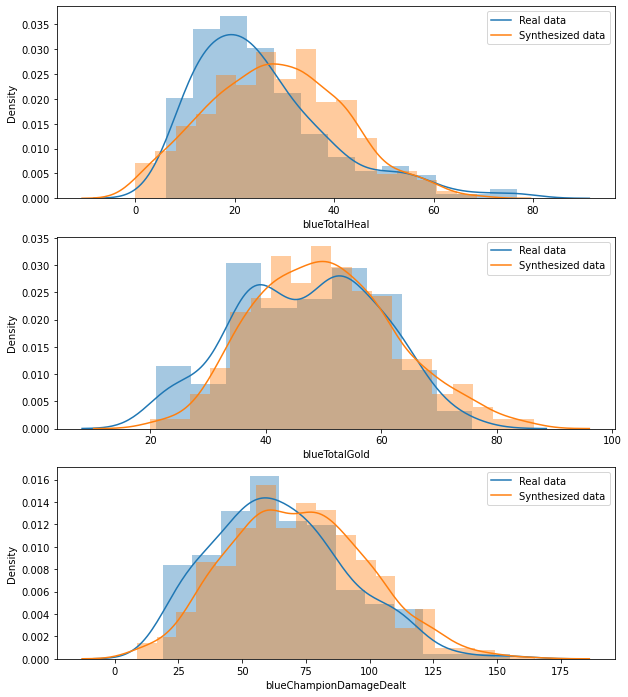

In [8]:
coded_data, coder = code_categories(
    train, 'label', ['blueWins'])
discrete_data, coder = discretization(coded_data, 'equal_frequency', [
'blueTotalHeal',
'blueTotalGold',
'blueChampionDamageDealt',
'blueTotalMinionKills',
'blueWardPlaced',
'gameDuraton',
'blueWardkills',
'blueKills',
'blueDeath',
'blueJungleMinionKills',
'blueObjectDamageDealt'                                       
])
bayes_hc = structure_learning(discrete_data, 'HC', nodes_type, 'K2')
print("Obtained network structure", bayes_hc)
draw_BN(bayes_hc, nodes_type, 'bayes_hc')

params = parameter_learning(train, nodes_type, bayes_hc, 'simple')
save_structure(bayes_hc, 'bayes_hc_structure')
skel = read_structure('bayes_hc_structure')
save_params(params, 'p_bayes_hc_params')
params = read_params('p_bayes_hc_params')
bayes_hc = HyBayesianNetwork(skel, params)
synth_df = generate_synthetics(bayes_hc, nodes_sign, 'simple', 800)


figure, axes = plt.subplots(3, 1, figsize=(10, 12))

sns.distplot(test['blueTotalHeal'], ax=axes[0])
sns.distplot(synth_df['blueTotalHeal'], ax=axes[0])
axes[0].legend(['Real data', 'Synthesized data'])

sns.distplot(test['blueTotalGold'], ax=axes[1])
sns.distplot(synth_df['blueTotalGold'], ax=axes[1])
axes[1].legend(['Real data', 'Synthesized data'])

sns.distplot(test['blueChampionDamageDealt'], ax=axes[2])
sns.distplot(synth_df['blueChampionDamageDealt'], ax=axes[2])
axes[2].legend(['Real data', 'Synthesized data'])

print(calculate_acc(bayes_hc, test, [
      'blueTotalHeal', 'blueTotalGold', 'blueChampionDamageDealt'], 'simple')[0:2])

C:\Users\Professional\AppData\Local\Programs\Python\Python39\lib\site-packages\pgmpy\models\BayesianModel.py:8: FutureWarning: BayesianModel has been renamed to BayesianNetwork. Please use BayesianNewtork class, BayesianModel will be removed in future.
  warnings.warn(


Best metric is 12.7995
Generation num: 0
max_depth: 6, no improvements: 0
Number of mutation attempts exceeded. Please check composer requirements for correctness.
Number of mutation attempts exceeded. Please check composer requirements for correctness.
spent time: 1.9 min
Best metric is 12.7995
Generation num: 1
max_depth: 6, no improvements: 1
spent time: 1.9 min
Best metric is 12.7995
Generation num: 2
max_depth: 6, no improvements: 2
spent time: 2.0 min
Best metric is 12.7995
Generation num: 3
max_depth: 6, no improvements: 3
spent time: 2.0 min
Best metric is 12.7995
Generation num: 4
max_depth: 6, no improvements: 4
spent time: 2.1 min
Best metric is 12.7995
Generation num: 5
max_depth: 6, no improvements: 5
spent time: 2.1 min
Best metric is 12.799499999999998
Generation num: 6
max_depth: 6, no improvements: 6
spent time: 2.2 min
Best metric is 12.5399
Generation num: 7
max_depth: 6, no improvements: 0
spent time: 2.2 min
Best metric is 12.5399
Generation num: 8
max_depth: 6, no

C:\Users\Professional\AppData\Local\Programs\Python\Python39\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\Users\Professional\AppData\Local\Programs\Python\Python39\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\Users\Professional\AppData\Local\Programs\Python\Python39\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt you

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
({}, {'blueTotalHeal': 10.181, 'blueTotalGold': 12.357, 'blueChampionDamageDealt': 18.488})


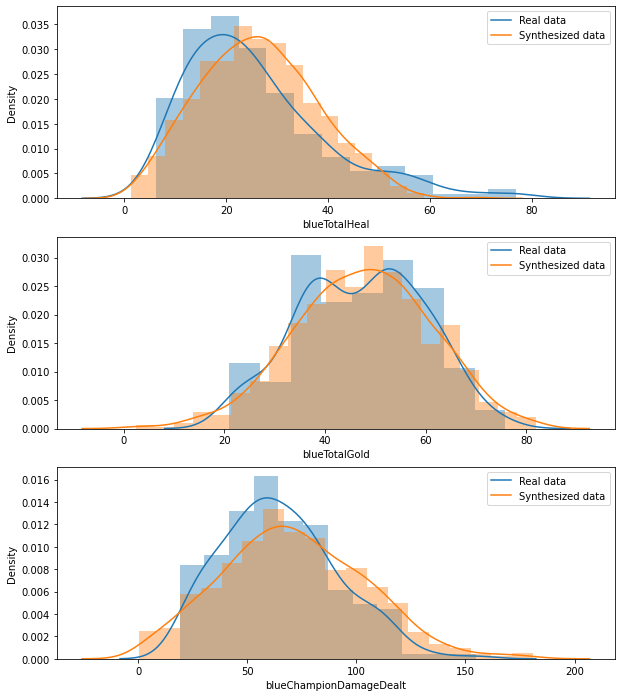

In [10]:
bayes_evo = structure_learning(discrete_data, 'evo', nodes_type, 'MI')
print("Obtained network structure", bayes_evo)
draw_BN(bayes_evo, nodes_type, 'bayes_evo')

params = parameter_learning(train, nodes_type, bayes_evo, 'simple')
save_structure(bayes_evo, 'bayes_evo_structure')
skel = read_structure('bayes_evo_structure')
save_params(params, 'bayes_evo_params')
params = read_params('bayes_evo_params')
bayes_evo = HyBayesianNetwork(skel, params)
synth_df = generate_synthetics(bayes_evo, nodes_sign, 'simple', 800)


figure, axes = plt.subplots(3, 1, figsize=(10, 12))

sns.distplot(test['blueTotalHeal'], ax=axes[0])
sns.distplot(synth_df['blueTotalHeal'], ax=axes[0])
axes[0].legend(['Real data', 'Synthesized data'])

sns.distplot(test['blueTotalGold'], ax=axes[1])
sns.distplot(synth_df['blueTotalGold'], ax=axes[1])
axes[1].legend(['Real data', 'Synthesized data'])

sns.distplot(test['blueChampionDamageDealt'], ax=axes[2])
sns.distplot(synth_df['blueChampionDamageDealt'], ax=axes[2])
axes[2].legend(['Real data', 'Synthesized data'])

print(calculate_acc(bayes_evo, test, [
      'blueTotalHeal', 'blueTotalGold', 'blueChampionDamageDealt'], 'simple')[0:2])